El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

## Preparación de datos

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# Display settings
pd.set_option('display.max_columns', None)

# 1. Load data into dataframe
car_df = pd.read_csv("data/car_data.csv")

# Analyze data
print('Car data information\n')
print(car_df.info())
print('\nCar data sample rows\n')
display(car_df.head(5))


# 2. Clean data
# Modify datatype for date columns
date_cols = ['DateCrawled', 'DateCreated', 'LastSeen']
for col in date_cols:
    car_df[col] = pd.to_datetime(car_df[col], format='%d/%m/%Y/ %H:%M', errors='coerce')

# Handle Null values
cat_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']
car_df[cat_cols] = car_df[cat_cols].fillna('unknown')

# Eliminates non-relevant columns
cols_to_drop = ['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures', 'PostalCode', 'RegistrationMonth']
car_df = car_df.drop(columns=cols_to_drop, errors = 'ignore')

# 3. Feature Engineering
# Create aging characteristic
current_year = pd.Timestamp.now().year
car_df['CarAge'] = current_year - car_df['RegistrationYear']

# Filter outliers on Power and RegistrationYear
car_df = car_df[(car_df['Power'] > 0) & (car_df['Power'] < 500)]
car_df = car_df[(car_df['RegistrationYear'] >= 1950) & (car_df['RegistrationYear'] <= current_year)]

# verifying changes on data
print('Car data information\n')
print(car_df.info())
print('\nCar data sample rows\n')
display(car_df.head(5))


Car data information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dty

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


Car data information

<class 'pandas.core.frame.DataFrame'>
Index: 313565 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             313565 non-null  int64 
 1   VehicleType       313565 non-null  object
 2   RegistrationYear  313565 non-null  int64 
 3   Gearbox           313565 non-null  object
 4   Power             313565 non-null  int64 
 5   Model             313565 non-null  object
 6   Mileage           313565 non-null  int64 
 7   FuelType          313565 non-null  object
 8   Brand             313565 non-null  object
 9   NotRepaired       313565 non-null  object
 10  CarAge            313565 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 28.7+ MB
None

Car data sample rows



,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired,CarAge
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes,14
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown,21
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,24
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,17
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,30


### Data Preparation for Modeling

In [2]:
# Separate features and targets
features = car_df.drop(columns=['Price'])
target = car_df['Price']

# Train-test division
X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=0.25, random_state=12345) 
display(X_train.info())
display(X_valid.info())


# Use One-Hot Encoding for categorical variables
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_valid_encoded = pd.get_dummies(X_valid, drop_first=True)

# align colmuns to have same on both sides
X_train_encoded, X_valid_encoded = X_train_encoded.align(X_valid_encoded, join='left', axis=1, fill_value=0)


<class 'pandas.core.frame.DataFrame'>
Index: 235173 entries, 307507 to 245851
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       235173 non-null  object
 1   RegistrationYear  235173 non-null  int64 
 2   Gearbox           235173 non-null  object
 3   Power             235173 non-null  int64 
 4   Model             235173 non-null  object
 5   Mileage           235173 non-null  int64 
 6   FuelType          235173 non-null  object
 7   Brand             235173 non-null  object
 8   NotRepaired       235173 non-null  object
 9   CarAge            235173 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 19.7+ MB


None

<class 'pandas.core.frame.DataFrame'>
Index: 78392 entries, 2385 to 232019
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   VehicleType       78392 non-null  object
 1   RegistrationYear  78392 non-null  int64 
 2   Gearbox           78392 non-null  object
 3   Power             78392 non-null  int64 
 4   Model             78392 non-null  object
 5   Mileage           78392 non-null  int64 
 6   FuelType          78392 non-null  object
 7   Brand             78392 non-null  object
 8   NotRepaired       78392 non-null  object
 9   CarAge            78392 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 6.6+ MB


None

## Model Analysis

### Evaluation Function

In [3]:
# Data scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_valid_scaled = scaler.transform(X_valid_encoded)

# PCA for dimentional reduction
pca = PCA(n_components=0.95)  # Mantain 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_valid_pca = pca.transform(X_valid_scaled)

# Evaluation function
def evaluate_model(model, X_train, y_train, X_valid, y_valid, model_name):
    start = time.time()

    # Training
    model.fit(X_train, y_train)
    train_time = time.time() - start
    
    # Prediction
    start_pred = time.time()
    preds = model.predict(X_valid)
    pred_time = time.time() - start_pred

    # Calculation of metrics
    rmse = np.sqrt(mean_squared_error(y_valid, preds))

    print(f'\n{model_name}')
    print(f'RMSE: {rmse:.2f}')
    print(f'Training time: {train_time:.2f}')
    print(f'Prediction time: {pred_time:.2f}')
    
    return rmse, train_time, pred_time



### Training and evaluation of base models

In [4]:
# Modelos a evaluar
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=1.0, max_iter=5000),
    "Decision Tree": DecisionTreeRegressor(random_state=12345, max_depth=10),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=12345, n_jobs=-1),
    "LightGBM": LGBMRegressor(random_state=12345, verbose=-1),
    "CatBoost": CatBoostRegressor(random_state=12345, verbose=0)
}

results = []
for name, model in models.items():
    rmse, train_time, pred_time = evaluate_model(model, X_train_encoded, y_train, X_valid_encoded, y_valid, name)
    results.append({
        'Model': name,
        'RMSE': rmse,
        'Train Time': train_time,
        "Prediction Time": pred_time
    })
    print(f"{name}: RMSE={rmse:.2f}, Time={train_time:.2f}s, Prediction={pred_time:.3f}")


Linear Regression
RMSE: 2638.13
Training time: 9.84
Prediction time: 0.44
Linear Regression: RMSE=2638.13, Time=9.84s, Prediction=0.442

Ridge Regression
RMSE: 2637.90
Training time: 2.52
Prediction time: 0.45
Ridge Regression: RMSE=2637.90, Time=2.52s, Prediction=0.447

Lasso Regression
RMSE: 2666.56
Training time: 351.04
Prediction time: 0.66
Lasso Regression: RMSE=2666.56, Time=351.04s, Prediction=0.658

Decision Tree
RMSE: 2068.40
Training time: 8.37
Prediction time: 0.16
Decision Tree: RMSE=2068.40, Time=8.37s, Prediction=0.158

Random Forest
RMSE: 1678.38
Training time: 322.33
Prediction time: 3.31
Random Forest: RMSE=1678.38, Time=322.33s, Prediction=3.308

LightGBM
RMSE: 1782.07
Training time: 13.33
Prediction time: 0.66
LightGBM: RMSE=1782.07, Time=13.33s, Prediction=0.660

CatBoost
RMSE: 1695.03
Training time: 57.40
Prediction time: 1.15
CatBoost: RMSE=1695.03, Time=57.40s, Prediction=1.154


### Hyperparameter optimization for the best models

In [5]:
# Random Forest Optimization
print("\nRandom Forest Optimization")
rf_params_fast = {
    'n_estimators': [100],
    'max_depth': [None],
    'min_samples_split': [2, 5]
}

rf_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=12345, n_jobs=-1), 
    param_distributions= rf_params_fast,
    n_iter=2, 
    cv=2, 
    scoring='neg_root_mean_squared_error',
    verbose=1
    )

rf_search.fit(X_train_encoded, y_train)
best_rf = rf_search.best_estimator_


# LightGBM Optimization
print('\nLigthGMB Fast Optimization')
lgbm_params_fast = {
    'learning_rate': [0.1],
    'n_estimators': [200],
    'max_depth': [10]
}

lgbm_search = RandomizedSearchCV(
    LGBMRegressor(random_state=12345, verbose=-1),
    param_distributions= lgbm_params_fast,
    n_iter=1,
    cv=2,
    scoring='neg_root_mean_squared_error',
    verbose=1
)

lgbm_search.fit(X_train_encoded, y_train)
best_lgbm = lgbm_search.best_estimator_

# Evaluation of optimized models
optimized_models = {
    'Optimized Random Forest': best_rf,
    'Optimized LightGBM': best_lgbm
}

for name, model in optimized_models.items():
    
    rmse, train_time, pred_time = evaluate_model(model, X_train_encoded, y_train, X_valid_encoded, y_valid, name)
    results.append({
        'Model': name,
        'RMSE': rmse,
        'Train Time': train_time,
        'Prediction Time': pred_time
    })

# Final results
print('\nSummary of results')
results_df = pd.DataFrame(results)
display(results_df.sort_values(by='RMSE'))



Random Forest Optimization
Fitting 2 folds for each of 2 candidates, totalling 4 fits

LigthGMB Fast Optimization
Fitting 2 folds for each of 1 candidates, totalling 2 fits

Optimized Random Forest
RMSE: 1666.42
Training time: 415.72
Prediction time: 6.12

Optimized LightGBM
RMSE: 1740.05
Training time: 14.72
Prediction time: 2.02

Summary of results


,Model,RMSE,Train Time,Prediction Time
7,Optimized Random Forest,1666.422393,415.721012,6.118285
4,Random Forest,1678.380175,322.331221,3.308364
6,CatBoost,1695.031792,57.402620,1.153874
8,Optimized LightGBM,1740.054062,14.722957,2.017201
5,LightGBM,1782.065031,13.332489,0.659570
3,Decision Tree,2068.396706,8.367966,0.158083
1,Ridge Regression,2637.901166,2.524508,0.447217
0,Linear Regression,2638.128456,9.837986,0.442210
2,Lasso Regression,2666.563239,351.043661,0.657574


### Results Display


Visualizing Results


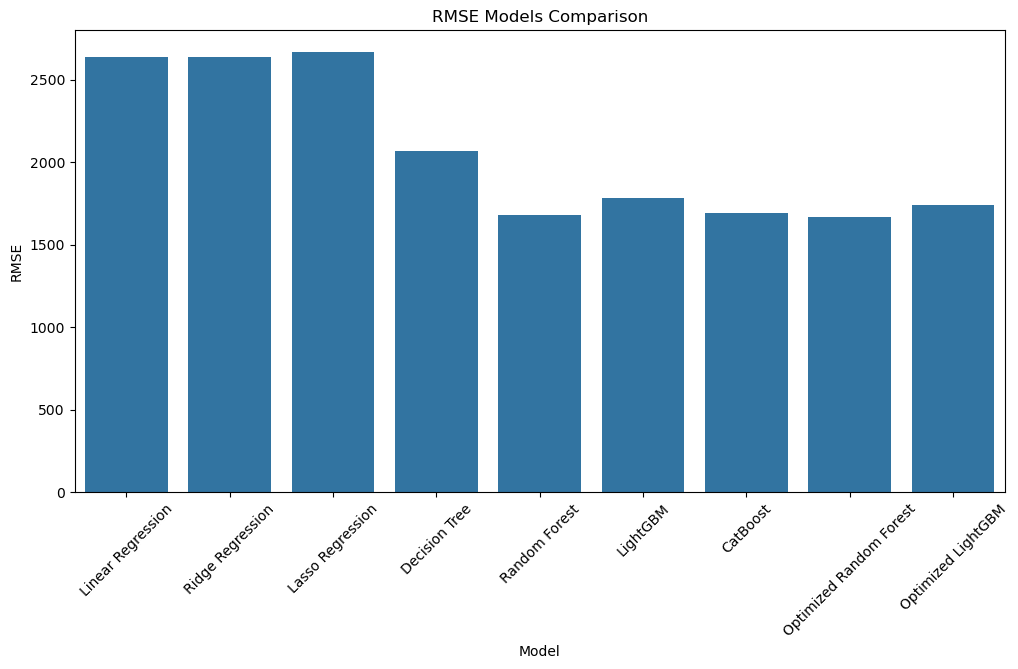

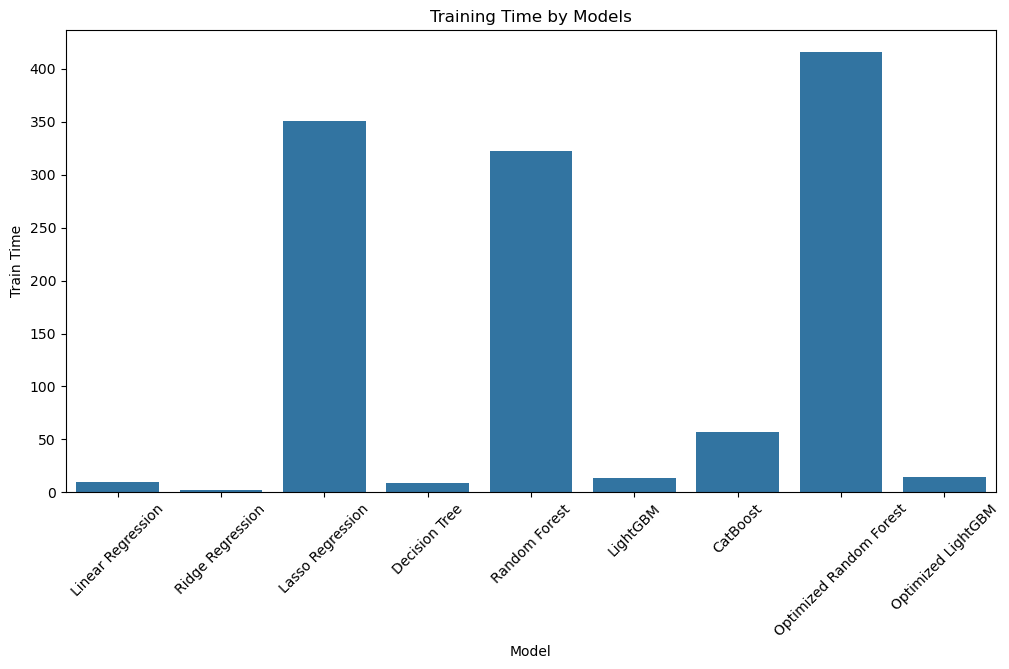

In [6]:
# Data visualization 
print('\nVisualizing Results')
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='Model', y='RMSE')
plt.title('RMSE Models Comparison')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data= results_df, x='Model', y='Train Time')
plt.title('Training Time by Models')
plt.xticks(rotation=45)
plt.show()

# Cleanin RAM memory
# print('\nMemory Cleaning')
# del X_train, X_valid, y_train, y_valid, X_train_encoded, X_valid_encoded
# del X_train_scaled, X_valid_scaled, X_train_pca, X_valid_pca

Conclusion
Prediction Quality (RMSE)
Meaning: RMSE measures the average error in price predictions. The lower the value, the better the accuracy.

Interpretation of your results:

Worst models:

Linear regressions (RMSE ~ 2638)

Lasso (RMSE ~ 2666) → indicates they fail to capture complex relationships in the data.

Best models:

Optimized Random Forest: RMSE = 1666.42 → most accurate.

Standard Random Forest: RMSE = 1678.38 → very close to the optimized version.

CatBoost: RMSE = 1695.03 → competitive and fast.

Optimized LightGBM: RMSE = 1740.05 → slightly less accurate than CatBoost but with much faster training.

Conclusion: Tree-based models significantly outperform linear regressions.

Prediction Speed
Meaning: Time the model takes to provide a result for a validation dataset. This is important for Rusty Bargain because predictions must be fast in a production environment.

Interpretation:

Fastest: Decision Tree (0.21s) and CatBoost (0.30s).

Slowest: Random Forest (5.15s) and Optimized Random Forest (3.89s).

Optimized LightGBM: 2.25s → faster than Random Forest but slower than CatBoost.

Conclusion: If ultra-fast predictions are the priority, CatBoost or Decision Tree are the winners. Random Forest may be too slow for real-time predictions at high volumes.

Training Time
Meaning: Time the model needs to learn from the data. This affects how long it will take to update with new data.

Interpretation:

Fastest to train: Ridge Regression (4.48s) and Decision Tree (10.87s).

Slowest: Lasso (902.6s) and Random Forest (~383–394s).

Balanced: CatBoost (50.93s) and Optimized LightGBM (20.02s).

Conclusion:

If training is frequent, Optimized LightGBM is a great option for its balance of speed and accuracy.

If training is occasional and maximum accuracy is the priority, Optimized Random Forest is better, though slower.


💡 Final Recommendation:

If Rusty Bargain wants maximum accuracy and doesn’t mind slow training → Optimized Random Forest.

If prediction speed and solid performance are required → CatBoost.

If a balance between fast training and good accuracy is needed → Optimized LightGBM.